# Phase 3 Project

## 1. Business Problem and Understanding

[place holder for stakeholders & background info]

**The goal:** Create a model to predict churn in telecom members contacting support. We are aiming to reduce the amount of cases in which members are mistakenly identified as retained (false negative) vs mistakenly identified as churned to ensure we capture all members who may churn (positive).

In [209]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder

In [210]:
# Load in csv

df = pd.read_csv('Data/tel_cust_curn.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## 2. Data Exploration

The dataset has no missingness and most columns are numeric. Will have to explore the object type columns to assess whether to drop or transform. With 3333 entries, the dataset is not small but not the largest, depending on the distribution of the target, may need to consider re-sampling.

It looks like our columns names all have spaces where underscores should be so we will want to adjust that. We will note this in our *pre-split* steps.

In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [211]:
# Rename columns with '_' instead of spaces

df.columns = df.columns.str.replace(' ','_')
df.columns

Index(['state', 'account_length', 'area_code', 'phone_number',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'customer_service_calls', 'churn'],
      dtype='object')

It looks like we definitely have **class imbalance** and will have to address that in our preprocessing, after splitting our train/test data.

In [157]:
df['churn'].value_counts(normalize=True)

churn
False    0.855086
True     0.144914
Name: proportion, dtype: float64

There seems to be very few outliers in the numeric columns. Though columns like `number_vmail_messages` and `total_day_calls` do have minimums of 0, depending on the frequency of these cases, these may need to be dropped. There is also a member who has been with the company longer than others as seen in `account_length`.

In [158]:
df.describe()

,account_length,area_code,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


It looks like `phone_number` is an object type, not sure we can do anything with that information as far as predictions, but we can turn it into a unique identifier for the customer. `international_plan` and `voice_main_plan` can be transformed to a binary numeric format and `state` is nominal so can be transformed to numeric as well.

In [131]:
df.select_dtypes('object')

,state,phone_number,international_plan,voice_mail_plan
0,KS,382-4657,no,yes
1,OH,371-7191,no,yes
2,NJ,358-1921,no,no
3,OH,375-9999,yes,no
4,OK,330-6626,yes,no
...,...,...,...,...
3328,AZ,414-4276,no,yes
3329,WV,370-3271,no,no
3330,RI,328-8230,no,no
3331,CT,364-6381,yes,no


Looking at numeric datatype columns, it seems like we can consolidate certain information that seems to be telling us the same thing. Columns pertaining to minutes, calls, and charge per time of day can most likely be combined to represent each time of day by a combined metric or one of the 3 columns which best represents level of contact per time of day. This same concept can be applies to `intl` calls which it looks like represent 'international' calls.

In [132]:
df.select_dtypes('number')

,account_length,area_code,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls
0,128,415,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,415,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,415,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,408,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,415,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,415,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2
3329,68,415,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3
3330,28,510,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2
3331,184,510,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2


## 3. Data Preperation

Before we transform columns, we will split our data into train and test sets. For our base model we will keep the train/test split as the default .75/.25 respectively. Since we know we have class imbalance, we will turn `stratify` to `True` so our class proportions stay the same for both our train and test data.

In [226]:
# Define X and y, and split train/test data
df_copy = df.copy()

X = df_copy.drop(columns=['churn'],axis=1)
y = df_copy['churn']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=7,stratify=y)

### Initial Preprocessing

In [227]:
# Transform target

y_train = y_train.astype(int)
y_test = y_test.astype(int)

print('y_train')
print(y_train.value_counts(normalize=True))
print('')
print('y_test')
print(y_test.value_counts(normalize=True))

y_train
churn
0    0.855142
1    0.144858
Name: proportion, dtype: float64

y_test
churn
0    0.854916
1    0.145084
Name: proportion, dtype: float64


In [228]:
def init_processing(X):
    '''
    Initial processing, takes in train and test data.
    '''
    # transfrom y/n columns to 1/0
    X['international_plan'] = X['international_plan'].map({'yes':1,'no':0})
    X['voice_mail_plan'] = X['voice_mail_plan'].map({'yes':1,'no':0})
    # make 'state' uppercase to eliminate inconsitencies 
    X['state'] = X['state'].str.upper()
    # turn `phone_number` into int
    X['phone_number'] = X['phone_number'].str.replace('-','').astype(int)
    return X

X_train = init_processing(X_train)
X_train

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls
2965,WI,103,415,3868943,0,0,0,180.2,134,30.63,97.7,85,8.30,181.7,134,8.18,8.4,3,2.27,1
692,NE,82,408,3432741,0,0,0,185.8,36,31.59,276.5,134,23.50,192.1,104,8.64,5.7,7,1.54,4
64,NC,38,408,3594081,0,0,0,131.2,98,22.30,162.9,97,13.85,159.0,106,7.15,8.2,6,2.21,2
1005,ND,12,510,3795211,1,0,0,216.7,117,36.84,116.5,126,9.90,220.0,110,9.90,9.8,4,2.65,2
2892,DE,103,415,3465053,0,1,34,138.8,80,23.60,142.0,108,12.07,183.8,77,8.27,11.8,7,3.19,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,OH,169,408,4015169,0,0,0,147.2,115,25.02,161.9,123,13.76,142.1,103,6.39,7.2,6,1.94,3
2038,TX,136,408,3354888,0,0,0,269.8,106,45.87,228.8,101,19.45,257.5,106,11.59,10.1,8,2.73,1
3300,SC,111,415,4188969,0,1,21,127.1,94,21.61,228.3,116,19.41,166.7,108,7.50,7.1,3,1.92,1
3313,ID,127,408,3925090,0,0,0,102.8,128,17.48,143.7,95,12.21,191.4,97,8.61,10.0,5,2.70,1


In [231]:
# Tranform 'state' column with OneHotEncoder

ohe = OneHotEncoder(drop="first", sparse_output=False, handle_unknown='ignore')
ohe_df = pd.DataFrame(ohe.fit_transform(X_train[['state']]),columns=ohe.get_feature_names_out(['state']),index=X_train.index)
X_train.drop(columns=['state'],axis=1,inplace=True)
X_train = pd.concat([X_train,ohe_df],axis=1)
X_train

,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
2965,103,415,3868943,0,0,0,180.2,134,30.63,97.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
692,82,408,3432741,0,0,0,185.8,36,31.59,276.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,38,408,3594081,0,0,0,131.2,98,22.30,162.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1005,12,510,3795211,1,0,0,216.7,117,36.84,116.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2892,103,415,3465053,0,1,34,138.8,80,23.60,142.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,169,408,4015169,0,0,0,147.2,115,25.02,161.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2038,136,408,3354888,0,0,0,269.8,106,45.87,228.8,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3300,111,415,4188969,0,1,21,127.1,94,21.61,228.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3313,127,408,3925090,0,0,0,102.8,128,17.48,143.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Correlation Analysis

To assess whether previously mentioned columns should be combined, we can look into the correlation between them. Looking at the heatmap below, while hard to read, we can clearly see that the state is not significantly correlated with any of the other features. Which means we can take a closer look at the features that may have a greater interaction. 

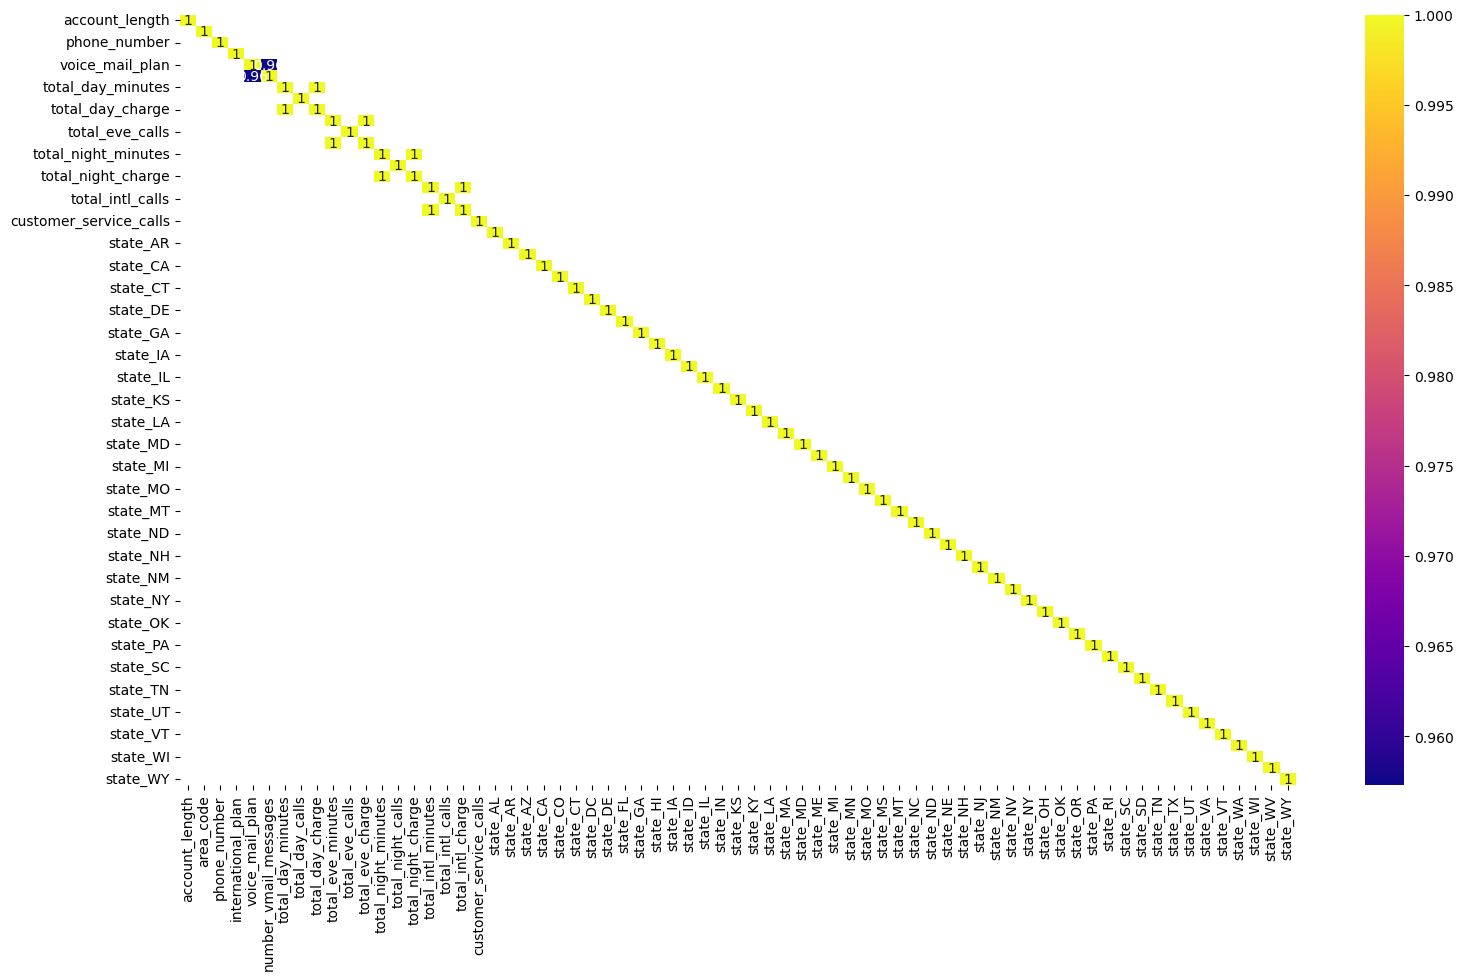

In [271]:
# Correlation analysis

fig, ax = plt.subplots(figsize=(18,10))

corr_matrix = X_train.corr(min_periods=400)
corr_matrix = corr_matrix[corr_matrix.abs()>.1]

sns.heatmap(corr_matrix,annot=True,cmap='plasma');

We can now see clearly that charge and minutes are perfectly correlated, which makes sense if the company is charging per minute. If we need to, we can confidently drop the 'charge' column from each category; day, eve, night, and intl. We can keep the 'minutes' category as it is unclear what currency metric 'charge' is referring to.

Lastly, there is a near perfect correlation between `number_vmail_messages` and `voice_mail_plan` this makes sense and these two columns much like 'charge' and 'minutes' are telling us the same thing. If we need to, we can drop `number_vmail_messages`.

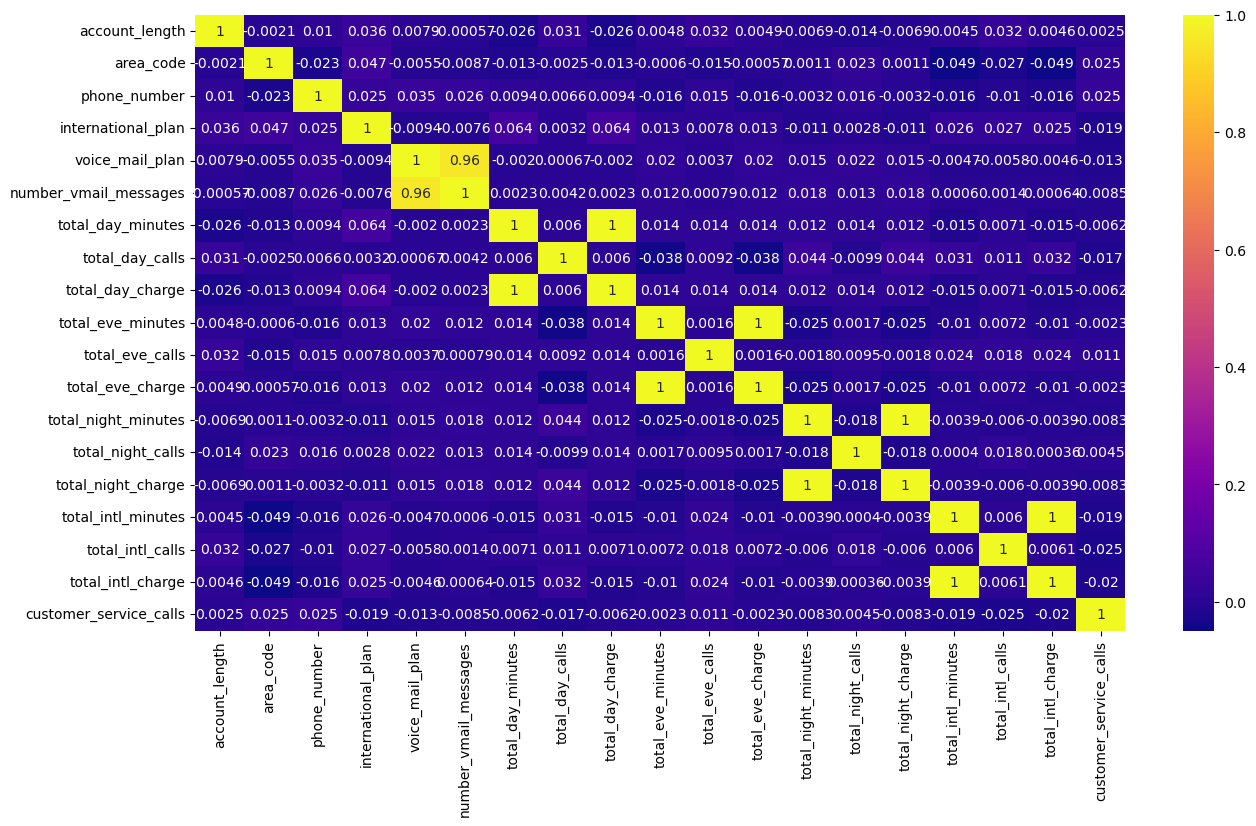

In [275]:
fig, ax = plt.subplots(figsize=(15,8))

non_state_cols = [col for col in X_train.columns if 'state' not in col]

sns.heatmap(X_train[non_state_cols].corr(min_periods=400),annot=True,cmap='plasma');